In [269]:
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
from __future__ import division

%matplotlib inline
sys.path.append("../tools/")

from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

### Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".

### financial features: ['salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 
### 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 
### 'other', 'long_term_incentive', 'restricted_stock', 'director_fees'] (all units are in US dollars)
### email features: ['to_messages', 'email_address', 'from_poi_to_this_person', 'from_messages', 
### 'from_this_person_to_poi', 'shared_receipt_with_poi'] 
### (units are generally number of emails messages; notable exception is ‘email_address’, which is a text string)
### POI label: [‘poi’] (boolean, represented as integer)

# You will need to use more features
features_list = ['poi','salary', 'bonus', 'total_payments', 'total_stock_value', 'expenses', 
                 'exercised_stock_options', 'other', 'long_term_incentive', 'from_poi_to_this_person', 
                 'from_this_person_to_poi','shared_receipt_with_poi'] 


### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

### Exploratory Data Analysis
print 'Total number of data points:', len(data_dict)

# Number of POI/non-POI
num_poi = 0
num_nonpoi = 0
for x in data_dict:
    if data_dict[x]['poi']:
        num_poi += 1
    elif not data_dict[x]['poi']:
        num_nonpoi += 1

print 'Number of POI is {0}, and number of non-POI is {1}.'.format(num_poi, num_nonpoi)   

Total number of data points: 146
Number of POI is 18, and number of non-POI is 128.


In [270]:
# Change dictionary to dataframe
full_data = pd.DataFrame.from_dict(data_dict, orient='index')
full_data.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


Number of missing values for each variable: 
{'bonus': 64,
 'deferral_payments': 107,
 'deferred_income': 97,
 'director_fees': 129,
 'email_address': 35,
 'exercised_stock_options': 44,
 'expenses': 51,
 'from_messages': 60,
 'from_poi_to_this_person': 60,
 'from_this_person_to_poi': 60,
 'loan_advances': 142,
 'long_term_incentive': 80,
 'other': 53,
 'restricted_stock': 36,
 'restricted_stock_deferred': 128,
 'salary': 51,
 'shared_receipt_with_poi': 60,
 'to_messages': 60,
 'total_payments': 21,
 'total_stock_value': 20}


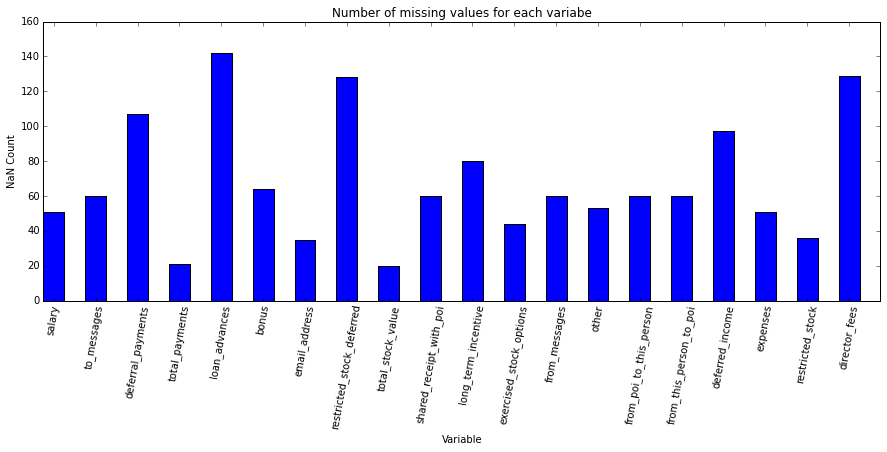

In [271]:
# Get the NaN number for each variable
nan_dict = {}
for x in full_data.columns:
    if x != 'poi':
        nan_dict[x] = sum(full_data[x]=='NaN')
        
print 'Number of missing values for each variable: '
pprint(nan_dict)
        
plt.figure(figsize=(15, 5))
bar_width = 0.5
plt.bar(range(len(nan_dict)), nan_dict.values(), bar_width)
plt.xticks(np.array(range(len(nan_dict))) + bar_width/2, nan_dict.keys(), rotation=80)
plt.xlabel('Variable')
plt.ylabel('NaN Count')
plt.title('Number of missing values for each variabe')

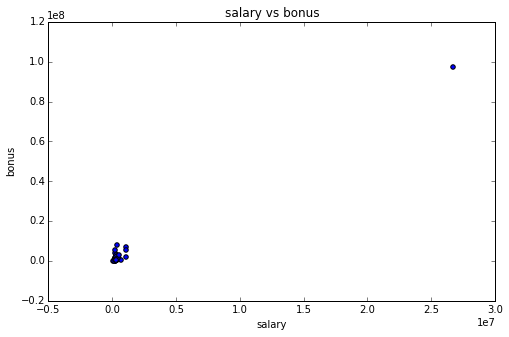

In [272]:
# Find outlier
plt.figure(figsize=(8, 5))
plt.scatter(full_data['salary'], full_data['bonus'])
plt.xlabel('salary')
plt.ylabel('bonus')
plt.title('salary vs bonus')

In [273]:
### Task 2: Remove outliers
tmp = full_data['salary'].copy()
tmp[tmp=='NaN'] = -999
ind = tmp > 1e7
good_data = full_data[-ind]

In [274]:
### Task 3: Create new feature(s)
# Two new features are created.
# One is sacled_to_poi = from_this_person_to_poi / from_messages
# The other one is scaled_from_poi = from_poi_to_this_person_ / to_messages
good_data['scaled_to_poi'] = good_data['from_this_person_to_poi'].astype(float) / good_data['from_messages'].astype(float)
good_data['scaled_from_poi'] = good_data['from_poi_to_this_person'].astype(float) / good_data['to_messages'].astype(float)


/Users/yanshi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yanshi/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


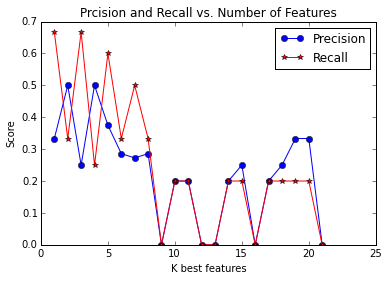

In [275]:
# Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Get rid of columns with missing value greater than 55%
tmp1 = nan_dict.values() 
tmp2 = nan_dict.keys()
col_missing = list(np.array(tmp2)[np.array(tmp1) > len(data_dict)*0.55])

tmp = good_data.columns
tmp.drop(col_missing)
tmp_df = good_data.ix[:, tmp.drop(['poi', 'email_address'])].astype(float)
tmp_df = tmp_df.fillna(0)

# Use Univariate selection method to choose useful features

def select_Kfeatures(k, tmp_df, good_data):
    """
    For select the best K features.
    """
    from sklearn.metrics import f1_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.naive_bayes import GaussianNB
    from sklearn.cross_validation import train_test_split
    from sklearn import tree
    
    selectK = SelectKBest(f_classif, k = k).fit(tmp_df, good_data['poi'].astype(int))

    # Change useful features into dictionary
    new_df = tmp_df.copy()
    new_df['poi'] = good_data['poi']
    new_dict = new_df.to_dict(orient='index')

    # Assign the selected feature to the feature list
    features_list = list(new_df.columns[selectK.get_support()])
    features_list.append('poi')
    features_list.reverse()

    new_dataset = new_dict

    ### Extract features and labels from dataset for local testing
    data = featureFormat(new_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    
    features_train, features_test, labels_train, labels_test = \
        train_test_split(features, labels, test_size=0.3, random_state=42)
    # clf = GaussianNB().fit(features_train, labels_train)
    clf = tree.DecisionTreeClassifier().fit(features_train, labels_train)

    prec_score = precision_score(labels_test, clf.predict(features_test))
    recal_score = recall_score(labels_test, clf.predict(features_test))
    clf = None
    return prec_score, recal_score, k


N = []
prec_score = []
recal_score = []
for k in range(tmp_df.shape[1]):
    tmp1, tmp2, tmp3 = select_Kfeatures(k+1, tmp_df, good_data)
    N.append(tmp3)
    prec_score.append(tmp1)
    recal_score.append(tmp2)
    
# plot score vs precision and recall
plt.plot(N, prec_score, '-o')
plt.plot(N, recal_score, '-r*')
plt.xlabel("K best features")
plt.ylabel("Score")
plt.legend(["Precision", "Recall"])
plt.title("Prcision and Recall vs. Number of Features")
plt.savefig("Kbest.pdf")

In [276]:
selectK = SelectKBest(f_classif, k = 5).fit(tmp_df, good_data['poi'].astype(int))

print "Score generated by SelectKBest:"
scores_list,feat_list = (list(x) for x in zip(*sorted(zip(selectK.scores_,features_list[1:]), reverse=True, key=lambda pair: pair[0])))
for i in range(len(feat_list)):
      print scores_list[i],feat_list[i]

Score generated by SelectKBest:
25.3801052998 expenses
24.7525230203 from_this_person_to_poi
21.327890414 exercised_stock_options
18.8617953165 salary
9.48074320348 other
8.96781934768 total_stock_value
8.90382155717 long_term_incentive
6.3746144902 shared_receipt_with_poi
1.75169427903 bonus
0.20970584227 total_payments
0.0644770280387 from_poi_to_this_person


Selected features:
Index([u'salary', u'exercised_stock_options', u'bonus', u'total_stock_value',
       u'scaled_to_poi'],
      dtype='object')


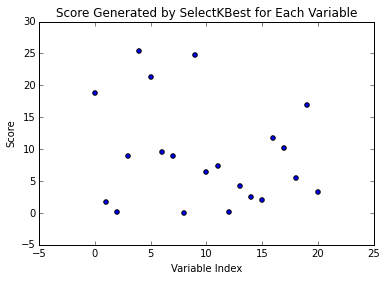

In [277]:
# print 'Score generated by SelectKBest:'
# pprint(zip(tmp_df.columns, selectK.scores_))
plt.scatter(range(len(selectK.scores_)),selectK.scores_)
plt.xlabel('Variable Index')
plt.ylabel('Score')
plt.title('Score Generated by SelectKBest for Each Variable')

print 'Selected features:'
print tmp_df.columns[selectK.get_support()]

In [278]:
# Change useful features into dictionary
tmp_df['poi'] = good_data['poi']
new_dict = tmp_df.to_dict(orient='index')

In [279]:
# Assign the selected feature to the feature list
features_list = list(tmp_df.columns[selectK.get_support()])
features_list.append('poi')
features_list.reverse()
### Store to my_dataset for easy export below.
my_dataset = new_dict

### Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)

In [280]:
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# precision and recall: http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    
# Gaussian Naive Bayes
clf = GaussianNB().fit(features_train, labels_train)
print "GuassianNB performance: "
print 'Precision score is:', precision_score(labels_test, clf.predict(features_test))
print 'Recall score is:', recall_score(labels_test, clf.predict(features_test))
print 'F1 score is:', f1_score(labels_test, clf.predict(features_test))

GuassianNB performance: 
Precision score is: 0.25
Recall score is: 0.2
F1 score is: 0.222222222222


In [281]:
# Decision Tree
from sklearn import tree
clf = tree.DecisionTreeClassifier().fit(features_train, labels_train)
print "Decision Tree performance: "
print 'Precision score is:', precision_score(labels_test, clf.predict(features_test))
print 'Recall score is:', recall_score(labels_test, clf.predict(features_test))
print 'F1 score is:', f1_score(labels_test, clf.predict(features_test))

Decision Tree performance: 
Precision score is: 0.375
Recall score is: 0.6
F1 score is: 0.461538461538


In [282]:
### Task 5: Tune your classifier to achieve better than .3 precision and recall
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info:
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!


In [283]:
from sklearn import grid_search
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipe = Pipeline(steps=[('minmaxer', MinMaxScaler()), ('tmp', tree.DecisionTreeClassifier())])
parameters = {'tmp__criterion': ('gini', 'entropy'), 'tmp__max_features': ('auto', 'log2', 'sqrt')}

cv = StratifiedShuffleSplit(labels_train,n_iter = 50,random_state = 42)
a_grid_search = grid_search.GridSearchCV(pipe, param_grid = parameters, cv = cv,scoring = 'recall'
                            ).fit(features_train, labels_train)
# pick a winner
clf = a_grid_search.best_estimator_ # This is the best classifier

In [284]:
print "Decision Tree performance on testing dataset: "
print 'Precision score is:', precision_score(labels_test, clf.predict(features_test))
print 'Recall score is:', recall_score(labels_test, clf.predict(features_test))
print 'F1 score is:', f1_score(labels_test, clf.predict(features_test))

Decision Tree performance on testing dataset: 
Precision score is: 0.5
Recall score is: 0.8
F1 score is: 0.615384615385


In [285]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

In [286]:
%run tester.py

Pipeline(steps=[('minmaxer', MinMaxScaler(copy=True, feature_range=(0, 1))), ('tmp', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features='log2', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.80750	Precision: 0.32789	Recall: 0.33100	F1: 0.32944	F2: 0.33037
	Total predictions: 14000	True positives:  662	False positives: 1357	False negatives: 1338	True negatives: 10643

